# NLP: Project 1

**Name: Patrick Murphy**

## WRDS list of S&P500 companies

In [2]:
import pandas as pd
import wrds

Here is the setup to obtain the companies list that consitute the S&P500 during December 30, 2022.

In [ ]:
conn=wrds.Connection()

In [ ]:
# Linking with Compustat through CCM

ccm=conn.raw_sql("""
                  select gvkey, liid as iid, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """, date_cols=['linkdt', 'linkenddt'])

# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

sp500 = conn.raw_sql("""
                        select a.*, b.date, b.ret
                        from crsp.msp500list as a,
                        crsp.msf as b
                        where a.permno=b.permno
                        and b.date >= a.start and b.date<= a.ending
                        and b.date>='01/01/2000'
                        order by date;
                        """, date_cols=['start', 'ending', 'date'])

# Add Other Descriptive Variables

mse = conn.raw_sql("""
                        select comnam, ncusip, namedt, nameendt, 
                        permno, shrcd, exchcd, hsiccd, ticker
                        from crsp.msenames
                        """, date_cols=['namedt', 'nameendt'])

# if nameendt is missing then set to today date
mse['nameendt']=mse['nameendt'].fillna(pd.to_datetime('today'))

# Merge with SP500 data
sp500_full = pd.merge(sp500, mse, how = 'left', on = 'permno')

# Impose the date range restrictions
sp500_full = sp500_full.loc[(sp500_full.date>=sp500_full.namedt) \
                            & (sp500_full.date<=sp500_full.nameendt)]

# Linking with Compustat through CCM

ccm=conn.raw_sql("""
                  select gvkey, liid as iid, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """, date_cols=['linkdt', 'linkenddt'])

# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

# Merge the CCM data with S&P500 data
# First just link by matching PERMNO
sp500ccm = pd.merge(sp500_full, ccm, how='left', on=['permno'])

# Then set link date bounds
sp500ccm = sp500ccm.loc[(sp500ccm['date']>=sp500ccm['linkdt'])\
                        &(sp500ccm['date']<=sp500ccm['linkenddt'])]

# Rearrange columns for final output

sp500ccm = sp500ccm.drop(columns=['namedt', 'nameendt', \
                                  'linktype', 'linkprim', 'linkdt', 'linkenddt'])
sp500ccm = sp500ccm[['date', 'permno', 'comnam', 'ncusip', 'shrcd', 'exchcd', 'hsiccd', 'ticker', \
                     'gvkey', 'iid', 'start', 'ending', 'ret']]

companies = sp500ccm[sp500ccm['date'] == '2022-12-30'].copy()
companies = companies[['comnam','ticker','ncusip','permno','gvkey']]
companies

## Mapping S&P500 companies to CIKs
Added two dictionaries two complete the dataframe with the CIKs of each S&P500 company. This will be useful when correlating the 10-Q reports to each company.

In [ ]:
from sec_cik_mapper import StockMapper
from pathlib import Path

def transform_dict_values_to_numeric(input_dict):
    return {key: int(value) for key, value in input_dict.items()}

def read_file_to_dict(filename):
    result_dict = {}
    with open(filename, 'r') as file:
        for line in file:
            key, value = line.strip().split('\t')
            result_dict[key.upper()] = int(value)
    return result_dict

def merge_dicts(dict1, dict2):
    merged_dict = dict1.copy()  # start with dict1's keys and values
    merged_dict.update(dict2)  # modifies merged_dict with dict2's keys and values
    return merged_dict

# Mapping Dictionary 1
mapper = StockMapper()
tick_to_cik = transform_dict_values_to_numeric(mapper.ticker_to_cik)

#Mapping Dictionary 2
filename = 'sec.gov_include_ticker.txt'
result_dict = read_file_to_dict(filename)

merged_tick_to_cik = merge_dicts(tick_to_cik, result_dict)

companies['CIK'] = pd.to_numeric(companies['ticker'].map(merged_tick_to_cik))
companies[companies['CIK'].isnull()]

Still, some companies are missing. Added the CIKs manually in this case, with the help of a dictionary.

In [ ]:
tickers_miss_cik = list(companies[companies['CIK'].isnull()]['ticker'])
col_n = companies.columns.get_loc('CIK')

missing_ciks = {
    'BRK': 1067983, 
    'BF': 14693, 
    'HCN': 1535385
}

for i in range(len(tickers_miss_cik)):
    row_index = companies[companies['ticker']==tickers_miss_cik[i]].index[0]
    companies.loc[row_index, 'CIK'] = missing_ciks[tickers_miss_cik[i]]
    
companies[companies['CIK'].isnull()]

Created a CSV to allow me to not run all the code all over again

In [ ]:
companies.to_csv('companies_data_cik.csv', index = False)

In [2]:
companies = pd.read_csv('companies_data_cik.csv')
companies

,comnam,ticker,ncusip,permno,gvkey,CIK
0,APPLIED MATERIALS INC,AMAT,03822210,14702.0,1704,6951.0
1,STRYKER CORP,SYK,86366710,73139.0,10115,310764.0
2,EQUINIX INC,EQIX,29444U70,89617.0,138743,1101239.0
3,NUCOR CORP,NUE,67034610,34817.0,8030,73309.0
4,ONEOK INC NEW,OKE,68268010,25232.0,8151,1039684.0
...,...,...,...,...,...,...
495,EQUITY RESIDENTIAL,EQR,29476L10,79547.0,28733,906107.0
496,HORMEL FOODS CORP,HRL,44045210,32870.0,5709,48465.0
497,CONSTELLATION ENERGY CORP,CEG,21037T10,22623.0,40614,1868275.0
498,SYSCO CORP,SYY,87182910,52038.0,10247,96021.0


## Getting 10-Qs master list
To obtain the 10-Qs we need to first get the master index files. These are text files that contain a list of all the documents released during a specific quarter of a year.

The master index files are hosted in the website https://www.sec.gov/Archives/edgar/full-index/. This is a directory that contains a folder for each year, and within them a folder for each quarter. Inside the quarter folders, we will find the master files under "master.idx".

We download them in a folder called master.

In [ ]:
import requests
heads = {'Host': 'www.sec.gov', 'Connection': 'close',
         'Accept': 'application/json, text/javascript, */*; q=0.01', 'X-Requested-With': 'XMLHttpRequest',
         'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36',
         }

def download(year):
    for qtr in range(1, 5):
        url = f"https://www.sec.gov/Archives/edgar/full-index/{year}/QTR{qtr}/master.idx"
        response = requests.get(url, headers=heads)
        print(url)
        response.raise_for_status()
        down_direct = r"C:\Users\patri\Notebooks\NLP\HW1\master" #Must be changed to fit the user

        with open(f'{down_direct}/{year}Q{qtr}.idx', 'wb') as f:
            f.write(response.content)

start_year = 2018
end_year = 2022

for i in range(start_year,end_year+1):
    download(i)

## Downloading 10-Qs

Here is the header of the master index file for the first quarter of the year 2018:

In [3]:
'''
Description:           Master Index of EDGAR Dissemination Feed
Last Data Received:    March 31, 2018
Comments:              webmaster@sec.gov
Anonymous FTP:         ftp://ftp.sec.gov/edgar/
Cloud HTTP:            https://www.sec.gov/Archives/

 
 
CIK|Company Name|Form Type|Date Filed|Filename
--------------------------------------------------------------------------------
1000032|BINCH JAMES G|4|2018-02-16|edgar/data/1000032/0000913165-18-000034.txt
1000045|NICHOLAS FINANCIAL INC|10-Q|2018-02-09|edgar/data/1000045/0001193125-18-037381.txt
1000045|NICHOLAS FINANCIAL INC|4|2018-02-15|edgar/data/1000045/0001000045-18-000004.txt
1000045|NICHOLAS FINANCIAL INC|4|2018-03-08|edgar/data/1000045/0001000045-18-000005.txt
1000045|NICHOLAS FINANCIAL INC|4|2018-03-20|edgar/data/1000045/0001609591-18-000001.txt
1000045|NICHOLAS FINANCIAL INC|8-K|2018-01-09|edgar/data/1000045/0001193125-18-007253.txt
1000045|NICHOLAS FINANCIAL INC|8-K|2018-02-05|edgar/data/1000045/0001193125-18-032199.txt
'''
print()

As we can see, not every file is a 10-Q, and not every company is part of the S&P500. We turn each master file into a pandas dataframe, to filter by these parameters. Later, we use the column Filename to download the files that are hosted in the SEC website.

The files are saved in a folder called '/10Qs' and the name of each file is 
> 'CIK_ticker_filing-date.txt' 

In [ ]:
import os
file_names = os.listdir('master')

import pandas as pd
import requests

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36'
}

def download_file(url, directory, local_filename):
    # Make directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)
    
    with requests.get(url, stream=True, headers=headers) as r:
        r.raise_for_status()
        with open(os.path.join(directory, local_filename), 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)
    return local_filename

for file_name in file_names:
    with open('master/'+file_name, 'r') as f:
        lines = f.readlines()

    # Find the line index where the table starts (where 'CIK' is found)
    start_line = next(i for i, line in enumerate(lines) if 'CIK' in line)

    # Read the table into a pandas DataFrame
    df = pd.read_csv('master/'+file_name, delimiter='|', skiprows=start_line+2, 
                     names=['CIK', 'Company Name', 'Form Type', 'Date Filed', 'Filename'])
    df = df.dropna()
    
    df = df[df['Form Type'] == '10-Q'] #Filter only 10-Q reports
    source_table = pd.merge(df, companies, how='inner', on='CIK') #Filter only S&P500 companies
    
    source_table['Filename'] = 'https://www.sec.gov/Archives/' + source_table['Filename']
    directory = '10Qs/'+file_name
    
    #Download files
    for link in source_table['Filename']:
        row = source_table[source_table['Filename'] == link]
        filename = str(row.iloc[0,0])+'_'+str(row.iloc[0,6])+'_'+str(row.iloc[0,3])+'.txt' #CIK, ticker, filing date
        print('downloaded '+ download_file(link, directory, filename))

## Sentiment analysis on 10Qs 
### Processing documents

Once we have downloaded the 10Qs and saved them as .txt, we process them one by one. We save the clean files in the 10Qs_clean directory. The name of each file is now 

> 'CIK_ticker_filing-date_clean.txt'

In [ ]:
import os
import re
from bs4 import BeautifulSoup
import nltk

# nltk.download('punkt')
# nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


def extract_and_parse(file_path):
    with open(file_path, 'r', encoding = 'utf-8') as file:
        data = file.read()

    document = re.search('<TEXT>(.*?)</TEXT>', data, re.DOTALL)

    if document:
        htm_data = document.group(1)
        
        # Parse the HTM content
        soup = BeautifulSoup(htm_data, 'html.parser')

        # Get the text without HTM tags
        text = soup.get_text()

        return text
    else:
        return "No document found"

def delete_before_substring(s):
    substring = 'UNITED STATESSECURITIES AND EXCHANGE COMMISSIONWASHINGTON'
    parts = s.split(substring)
    if len(parts) > 1:
        return substring + parts[1]
    else:
        return s

def replace_substring(s, old, new):
    # Replace all occurrences of old with new
    return s.replace(old, new)
    

def remove_and_process(text):
    # convert to lowercase
    text = text.lower()
    # removing non-alphabetical characters, like numbers and special characters
    text = re.sub('\d','',text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # remove hyperlinks
    text = re.sub(r"https?://\S+", "", text)
    # remove all html tags but keep its content
    text = re.sub(r"<.*?>", " ", text)
    # remove repeated characters
    text = re.sub(r'(.)\1{3,}',r'\1', text)
    # remove XBRL word
    text = re.sub('xbrl', '', text)
    # remove extra space, tabs, and line breaks 
    text = " ".join(text.split())
    return text    
    
def clean_text(text):
    # Tokenize the text
    words = nltk.word_tokenize(text)
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]

    # Define a minimum word length (adjust as needed)
    # Example: Remove words with fewer than 3 characters
    min_word_length = 3  

    # Filter out words that meet the criteria
    filtered_words = [word for word in filtered_words if len(word) > min_word_length]
    
    # Join the filtered words back into a single string
    cleaned_text = ' '.join(filtered_words)
    
    return cleaned_text


def process_text_from_file(file_path):
    text = extract_and_parse(file_path)
    text = delete_before_substring(text)
    text = replace_substring(text, '\xa0', ' ')
    text = remove_and_process(text)
    text = clean_text(text)
    return text

def produce_clean_text_file(file_name):
    directory = os.path.join('10Qs_clean', file_name.split('\\')[1])
    
    os.makedirs(directory, exist_ok=True)
    
    new_file_name = file_name.split('\\')[2][:-4] + '_clean.txt'
    
    if not os.path.isfile(os.path.join(os.getcwd(), directory, new_file_name)):
        print('processing: ', os.path.join(os.getcwd(), directory, new_file_name))
        
        text = process_text_from_file(file_name)
        with open(os.path.join(directory, new_file_name), 'w') as file:
            file.write(text)
            return

def process_files():
    for folder in os.listdir('10Qs'):
        for file_name in os.listdir(os.path.join('10Qs', folder)):
            file_path = os.path.join('10Qs', folder, file_name)
            produce_clean_text_file(file_path)

process_files()

### Sentiment Analysis

After saving the new processed files, we run the actual sentiment analysis. We calculate the **term and proportion weighting** of negative words according to the Harvard and Loughran&McDonald dictionaries.

In [ ]:
# import two word lists 
import harvard_wordlist 
import lm_neg_wordlist

hiv4_list = harvard_wordlist.harvard_neg
lm_neg_list = lm_neg_wordlist.lm_negative

# convert the words in the word_list to lower case 
hiv4_list = [word.lower() for word in hiv4_list]
lm_neg_list = [word.lower() for word in lm_neg_list]

# term frequenct/ word count
hiv4_wc = pd.DataFrame(columns=hiv4_list)
lm_wc = pd.DataFrame(columns=lm_neg_list)
# proportional weighting 
hiv4_pw = pd.DataFrame(columns=hiv4_list)
lm_pw = pd.DataFrame(columns=lm_neg_list)

# initialize hiv4_df dict
hiv4_df_dict = {word: 0 for word in hiv4_list}
lm_df_dict = {word: 0 for word in lm_neg_list}

In [ ]:
import os
import re

# helper function to read file_content from file_path
def read_doc(file_path):
    '''
    read file content
    input: file_path
    output: str type, file_content
    '''
    with open(file_path,'r') as file:
        file_content = file.read()
    return file_content 

# Count the occurence of one specific negative word in a specific doc 
def tf(file_content, word_list):
    '''
    count the occurence of each word in the word_lsit
    return (dict): word_counts
    '''
    word_counts = {word: 0 for word in word_list}
    # convert file_content into separate chars of words
    words = re.findall(r'\b\w+\b', file_content.lower()) 
    for word in words:
        if word in word_list:
            word_counts[word] += 1
    return word_counts


# loop through each file in the "cleaned_data" folder
i = 0 
total_length = 0

for folder in os.listdir('10Qs_clean'):
    for file_name in os.listdir(os.path.join('10Qs_clean', folder)):
        file_path = os.path.join('10Qs_clean', folder, file_name)

        file_content = read_doc(file_path)

        # added 
        words = file_content.split()
        file_length = len(words)


        # update total_length
        total_length += file_length

        hiv4_wc_dict = tf(file_content, hiv4_list)
        hiv4_pw_dict = {key: value / file_length if file_length !=0  else 0 for key, value in hiv4_wc_dict.items()}
        hiv4_wc.loc[file_name] = hiv4_wc_dict.values()
        hiv4_pw.loc[file_name] = hiv4_pw_dict.values()

        lm_wc_dict = tf(file_content, lm_neg_list)
        lm_pw_dict = {key: value / file_length if file_length !=0  else 0 for key, value in lm_wc_dict.items()}
        lm_wc.loc[file_name] = lm_wc_dict.values()
        lm_pw.loc[file_name] = lm_pw_dict.values()

        for word in words:
            if word in hiv4_list:
                hiv4_df_dict[word] += 1
            if word in lm_neg_list:
                lm_df_dict[word] += 1


        print("Done for: ", i)
        i += 1

In [ ]:
import numpy as np

# count the number of valid documents in the cleaned files folder
def count_docs(directory):
    file_count = 0
    for root, dirs, files in os.walk(directory):
        file_count += len(files)
    return file_count

root = os.getcwd()

# Count total number of files
N = count_docs(os.path.join(root, '10Qs_clean'))
    
# Average number of words in documents
a = total_length / N

def transform_value(x): # term weighting 
    return (1 + np.log(x)) / (1 + np.log(a)) if x != 0 else 0
    
hiv4_pw.to_csv("hiv4_pw.csv")
lm_pw.to_csv("lm_pw.csv")

# log(N/d_j)
hiv4_idf_dict = {key: (1/value) * N  if value !=0 else 0 for key, value in hiv4_df_dict.items()}
lm_idf_dict = {key: (1/value) * N  if value !=0 else 0 for key, value in lm_df_dict.items()}

# Transform the hiv4_wc and lm_wc term frequency dataframe 
hiv4_tw = hiv4_wc.applymap(transform_value) * pd.Series(hiv4_idf_dict)
lm_tw = lm_wc.applymap(transform_value) * pd.Series(lm_idf_dict)

# initialize a dataframe 
txt_neg_score = pd.DataFrame()
txt_neg_score['hiv4_pw'] = hiv4_pw.sum(axis=1)
txt_neg_score['lm_pw'] = lm_pw.sum(axis=1)
txt_neg_score['hiv4_tw'] = hiv4_tw.sum(axis=1)
txt_neg_score['lm_tw'] = lm_tw.sum(axis=1)

txt_neg_score.to_csv('scores.csv')

We saved the values on a .csv in order to not do the whole process again

In [23]:
neg_scores = pd.read_csv('scores.csv', index_col=0)
neg_scores

,hiv4_pw,lm_pw,hiv4_tw,lm_tw
1001250_EL_2018-02-02_clean.txt,0.024857,0.018913,11.432904,45.860635
1002047_NTAP_2018-02-22_clean.txt,0.030692,0.037696,46.156655,305.441566
100493_TSN_2018-02-08_clean.txt,0.025024,0.027647,205.601443,160.063529
1013237_FDS_2018-01-09_clean.txt,0.015778,0.013021,11.161569,96.486864
1024478_ROK_2018-01-31_clean.txt,0.020129,0.020516,4.203113,17.152543
...,...,...,...,...
96021_SYY_2022-11-02_clean.txt,0.020945,0.016291,4.175802,11.117381
96943_TFX_2022-10-27_clean.txt,0.028593,0.036850,6.856396,29.619374
97210_TER_2022-11-04_clean.txt,0.022492,0.018191,10.650152,35.036020
97476_TXN_2022-10-26_clean.txt,0.016657,0.013847,2.326818,7.784510


## Excess Returns

* Check if the filing date is a trading day, if not obtain the next one.
* For each filing date (or next trading day available), obtain the 6 months market returns.
* Obtain the market data for the ticker being analysed (6 months).
* Calculate the regression and the beta. 
* Calculate excess returns for the filing date and three days onwards.

#### Obtaining 6-month market data for each filing date

In [13]:
import yfinance as yf
import numpy as np
from datetime import datetime, timedelta

sp500 = yf.Ticker('^GSPC')
history = sp500.history(period = '1d', start = '2017-06-01', end = '2023-02-01')['Close']

mk_returns       = history/history.shift(1) - 1
mk_returns       = mk_returns.dropna()
mk_returns.index = mk_returns.index.strftime('%Y-%m-%d')
mk_returns.name  = 'market_returns'


def get_mk_returns(data):
    filing_date = data['filing_date']
    
    while(not filing_date in mk_returns.index):
        filing_date = datetime.strptime(filing_date,"%Y-%m-%d") + timedelta(days=1)
        filing_date = filing_date.strftime("%Y-%m-%d")
    
    # 6 months will be assumed to be 120 days prior to the filing date.
    n_row = mk_returns.index.get_loc(filing_date)
    start_date   = mk_returns.index[n_row - 120]
    end_date     = mk_returns.index[n_row]

    window = np.logical_and(mk_returns.index >= start_date, mk_returns.index < end_date)

    
    return mk_returns[window]

#### Obtaining market data for the ticker

In [20]:
import yfinance as yf

def previous_bd(date):
    return (datetime.strptime(date,"%Y-%m-%d") + timedelta(days=-1)).strftime('%Y-%m-%d')


def get_ticker_past_returns(data):
    filing_date = data['filing_date']
    
    while(not filing_date in mk_returns.index):
        filing_date = datetime.strptime(filing_date,"%Y-%m-%d") + timedelta(days=1)
        filing_date = filing_date.strftime("%Y-%m-%d")
    
    # I get the dates from the market returns, as I want them to match.
    n_row        = mk_returns.index.get_loc(filing_date)
    start_date   = mk_returns.index[n_row - 121]
    end_date     = mk_returns.index[n_row]
    

    ticker = yf.Ticker(data['ticker'])
    history = ticker.history(period = '1d', start = start_date, end = end_date)['Close']
    
    returns       = history/history.shift(1) - 1
    returns       = returns.dropna()
    returns.index = returns.index.strftime('%Y-%m-%d')
    returns.name  = data['ticker']
    
    return returns

#### Calculating Beta

In [21]:
import pandas as pd
import statsmodels.api as sm

def get_beta(data):
    # Define your pandas series
    series1 = get_ticker_past_returns(data)
    series2 = get_mk_returns(data)

    # In case series don't match.
    # Reset index to use date as a column for merging
    ts1_reset = series1.reset_index()
    ts2_reset = series2.reset_index()
    
    # Merge on date
    merged = pd.merge(ts1_reset, ts2_reset, on='Date', how='inner')

    # Set date back as index
    merged.set_index('Date', inplace=True)
    
    # Add a constant (intercept term) to the series
    merged = sm.add_constant(merged)

    # Fit the model
    model = sm.OLS(merged.iloc[:,2], merged.iloc[:,:2])
    results = model.fit()

    # The beta (slope) coefficient is in the second position of the results' params
    beta = results.params[data['ticker']]
    return beta

####  Calculate Excess Returns

We calculate the excess returns for the 3 days after the filing date of the reports.

$$\large \text{Excess Returns}_i = \sum_{t=1}^3 \text{StockReturn}_{i,t} - \beta_i * \sum_{t=1}^3 \text{MarketReturn}_t$$

In [22]:
import numpy as np
from datetime import datetime, timedelta

def excess_returns(data):
    filing_date = data['filing_date']
    ticker = yf.Ticker(data['ticker'])

    while(not filing_date in mk_returns.index):
        filing_date = datetime.strptime(filing_date,"%Y-%m-%d") + timedelta(days=1)
        filing_date = filing_date.strftime("%Y-%m-%d")
    
    n_row        = mk_returns.index.get_loc(filing_date)
    start_date   = mk_returns.index[n_row+1]
    end_date     = mk_returns.index[n_row+4]
    
    history = ticker.history(period = '1d', start = previous_bd(start_date), end = end_date)['Close']
    
    if history.empty:
        return np.nan
    
    returns       = history/history.shift(1) - 1
    returns       = returns.dropna()
    returns.index = returns.index.strftime('%Y-%m-%d')
    returns.name  = data['ticker']
    
    sum_returns = sum(returns)
    beta = get_beta(data)
    sum_mk_returns = sum(mk_returns.iloc[n_row+1:n_row+4])
    
    return sum_returns - beta*sum_mk_returns

In [25]:
df = pd.read_csv('scores.csv', index_col=0).reset_index()
_ = pd.DataFrame([x.split('_') for x in df['index'].tolist()])
df['ticker'] = _[1]
df['filing_date'] = _[2]
df['excess_returns'] = 0

,index,hiv4_pw,lm_pw,hiv4_tw,lm_tw,ticker,filing_date,excess_returns
0,1001250_EL_2018-02-02_clean.txt,0.024857,0.018913,11.432904,45.860635,EL,2018-02-02,0
1,1002047_NTAP_2018-02-22_clean.txt,0.030692,0.037696,46.156655,305.441566,NTAP,2018-02-22,0
2,100493_TSN_2018-02-08_clean.txt,0.025024,0.027647,205.601443,160.063529,TSN,2018-02-08,0
3,1013237_FDS_2018-01-09_clean.txt,0.015778,0.013021,11.161569,96.486864,FDS,2018-01-09,0
4,1024478_ROK_2018-01-31_clean.txt,0.020129,0.020516,4.203113,17.152543,ROK,2018-01-31,0
...,...,...,...,...,...,...,...,...
7359,96021_SYY_2022-11-02_clean.txt,0.020945,0.016291,4.175802,11.117381,SYY,2022-11-02,0
7360,96943_TFX_2022-10-27_clean.txt,0.028593,0.036850,6.856396,29.619374,TFX,2022-10-27,0
7361,97210_TER_2022-11-04_clean.txt,0.022492,0.018191,10.650152,35.036020,TER,2022-11-04,0
7362,97476_TXN_2022-10-26_clean.txt,0.016657,0.013847,2.326818,7.784510,TXN,2022-10-26,0


In [ ]:
for i in range(len(df)):
    df.loc[i, 'excess_returns'] = excess_returns(df.loc[i])
    
df.to_csv('excess_returns.csv')

## Correlating sentiment analysis with Excess Returns

In [42]:
result = pd.read_csv('excess_returns.csv', index_col=0)
result = excess_scores.dropna()
result.head()

,index,hiv4_pw,lm_pw,hiv4_tw,lm_tw,ticker,filing_date,excess_returns
0,1001250_EL_2018-02-02_clean.txt,0.024857,0.018913,11.432904,45.860635,EL,2018-02-02,0.005149
1,1002047_NTAP_2018-02-22_clean.txt,0.030692,0.037696,46.156655,305.441566,NTAP,2018-02-22,0.028223
2,100493_TSN_2018-02-08_clean.txt,0.025024,0.027647,205.601443,160.063529,TSN,2018-02-08,0.005955
3,1013237_FDS_2018-01-09_clean.txt,0.015778,0.013021,11.161569,96.486864,FDS,2018-01-09,0.017293
4,1024478_ROK_2018-01-31_clean.txt,0.020129,0.020516,4.203113,17.152543,ROK,2018-01-31,-0.055022


In [43]:
result['lm_rank']      = result['lm_tw'].rank(method='first')
result['hiv4_rank']    = result['hiv4_tw'].rank(method='first')
result['lm_pw_rank']   = result['lm_pw'].rank(method='first')
result['hiv4_pw_rank'] = result['hiv4_pw'].rank(method='first')

bin_labels = ['5', '4', '3', '2', '1']

result['lm_quantile'] = pd.qcut(result['lm_rank'].astype(int), 5, labels=bin_labels)
result['hiv4_quantile'] = pd.qcut(result['hiv4_rank'].astype(int), 5, labels=bin_labels)
result['lm_pw_quantile'] = pd.qcut(result['lm_pw_rank'].astype(int), 5, labels=bin_labels)
result['hiv4_pw_quantile'] = pd.qcut(result['hiv4_pw_rank'].astype(int), 5, labels=bin_labels)

quantile = result[['index', 'excess_returns', 'lm_quantile', 'hiv4_quantile', 'lm_pw_quantile', 'hiv4_pw_quantile']]
quantile.head()

,index,excess_returns,lm_quantile,hiv4_quantile,lm_pw_quantile,hiv4_pw_quantile
0,1001250_EL_2018-02-02_clean.txt,0.005149,4,4,4,3
1,1002047_NTAP_2018-02-22_clean.txt,0.028223,1,2,1,1
2,100493_TSN_2018-02-08_clean.txt,0.005955,2,1,2,2
3,1013237_FDS_2018-01-09_clean.txt,0.017293,3,4,5,5
4,1024478_ROK_2018-01-31_clean.txt,-0.055022,5,5,4,4


In [50]:
lm_quantile = quantile.groupby(['lm_quantile']).median()
hiv4_quantile = quantile.groupby(['hiv4_quantile']).median()
lm_pw_quantile = quantile.groupby(['lm_pw_quantile']).median()
hiv4_pw_quantile = quantile.groupby(['hiv4_pw_quantile']).median()

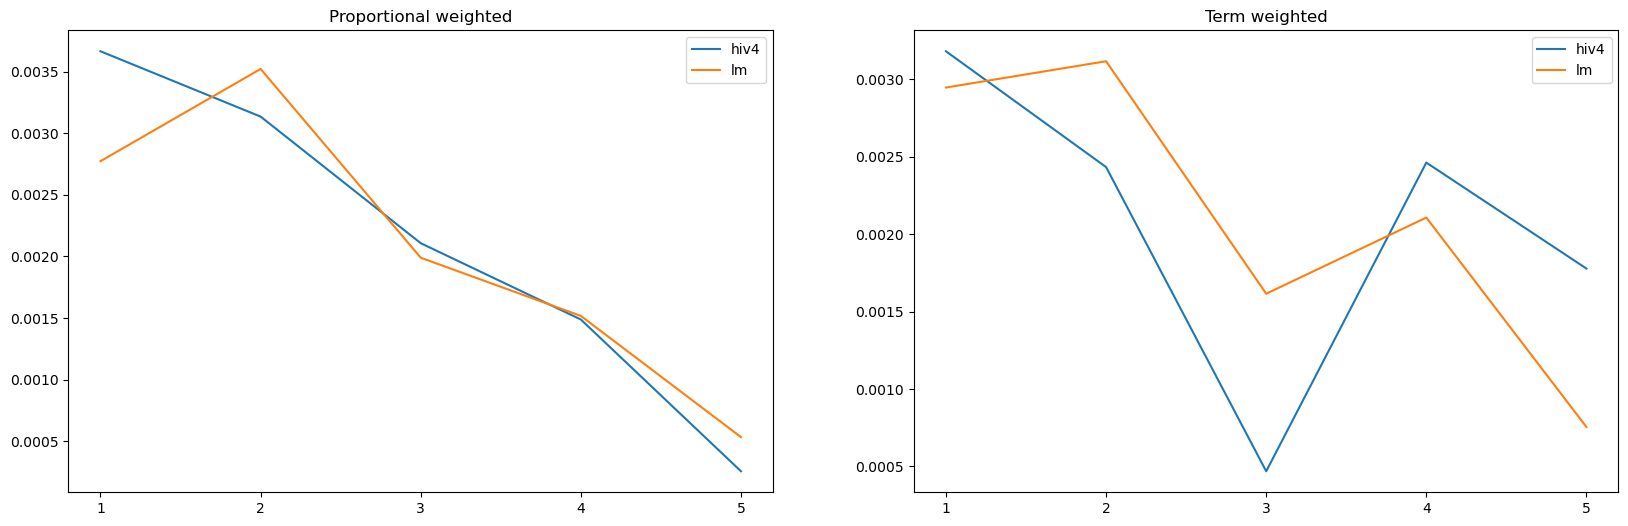

In [51]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

ax1.plot(hiv4_pw_quantile, label='hiv4')
ax1.plot(lm_pw_quantile, label='lm')
ax1.invert_xaxis()
ax1.legend()
ax1.set_title("Proportional weighted")

ax2.plot(hiv4_quantile, label='hiv4')
ax2.plot(lm_quantile, label='lm')
ax2.invert_xaxis()
ax2.legend()
ax2.set_title("Term weighted")

plt.show()